# Chapter 7: Artificial Neural Networks - Part 2

This notebook continues our exploration of Artificial Neural Networks (ANNs), focusing on advanced techniques, regularization methods, optimization strategies, and architectures. This is the second part of our neural network exploration.

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.layers import Flatten, Concatenate, Lambda, Add
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical, plot_model

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_wine, fetch_california_housing

# Configure visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


## 1. Advanced Regularization Techniques

Regularization is a set of techniques used to prevent overfitting in neural networks. In this section, we'll explore several advanced regularization methods.

### 1.1 L1, L2, and Elastic Net Regularization

- **L1 Regularization (Lasso)**: Adds a penalty equal to the absolute value of the weights, which can lead to sparse models with some weights exactly zero.
  - $L_{regularized} = L_{original} + \lambda \sum_{i=1}^{n} |w_i|$

- **L2 Regularization (Ridge)**: Adds a penalty equal to the square of the weights, which leads to smaller but non-zero weights.
  - $L_{regularized} = L_{original} + \lambda \sum_{i=1}^{n} w_i^2$

- **Elastic Net**: Combines L1 and L2 regularization to get the best of both worlds.
  - $L_{regularized} = L_{original} + \lambda_1 \sum_{i=1}^{n} |w_i| + \lambda_2 \sum_{i=1}^{n} w_i^2$

### 1.2 Other Regularization Techniques

- **Dropout**: Randomly sets a fraction of input units to 0 at each update during training time, which helps prevent co-adaptation of neurons.

- **Batch Normalization**: Normalizes the activations of the previous layer for each batch, reducing internal covariate shift and allowing higher learning rates.

- **Early Stopping**: Stops training when the validation performance starts to degrade, preventing overfitting.

- **Data Augmentation**: Creates new training examples by applying transformations to existing ones, increasing the effective size of the training set.

## 2. Implementing Regularization Techniques

Let's implement and compare different regularization techniques on a classification task using the Wine dataset.

In [4]:
# Load the Wine dataset
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names
target_names = wine.target_names

# Print basic information about the dataset
print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Target names: {target_names}")

Dataset shape: (178, 13)
Number of classes: 3
Class distribution: [59 71 48]
Target names: ['class_0' 'class_1' 'class_2']


In [5]:
# Create a DataFrame for easier data visualization
wine_df = pd.DataFrame(X, columns=feature_names)
wine_df['target'] = y
wine_df['wine_type'] = wine_df['target'].map({0: 'class_0', 1: 'class_1', 2: 'class_2'})

# Display the first few rows
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,wine_type
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,class_0


In [6]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert target to one-hot encoding for multi-class classification
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Validation set shape: {X_val_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")
print(f"One-hot encoded target shape: {y_train_one_hot.shape}")

Training set shape: (124, 13)
Validation set shape: (27, 13)
Testing set shape: (27, 13)
One-hot encoded target shape: (124, 3)


In [7]:
def create_regularized_model(input_shape, reg_type=None, reg_strength=0.01, dropout_rate=0.0, use_batch_norm=False):
    """Create a model with the specified regularization techniques."""
    model = Sequential()

    # Define regularizer based on reg_type
    if reg_type == 'l1':
        regularizer = l1(reg_strength)
    elif reg_type == 'l2':
        regularizer = l2(reg_strength)
    elif reg_type == 'l1_l2':
        regularizer = l1_l2(l1=reg_strength/2, l2=reg_strength/2)
    else:
        regularizer = None

    # Input layer
    model.add(Dense(64, input_shape=(input_shape,), kernel_regularizer=regularizer))

    # Apply batch normalization if specified
    if use_batch_norm:
        model.add(BatchNormalization())

    model.add(Activation('relu'))

    # Apply dropout if rate > 0
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # Hidden layer
    model.add(Dense(32, kernel_regularizer=regularizer))

    if use_batch_norm:
        model.add(BatchNormalization())

    model.add(Activation('relu'))

    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # Output layer (3 classes)
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [8]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Define model configurations to test
configurations = [
    {'name': 'No Regularization', 'reg_type': None, 'reg_strength': 0.0, 'dropout_rate': 0.0, 'use_batch_norm': False},
    {'name': 'L1 Regularization', 'reg_type': 'l1', 'reg_strength': 0.001, 'dropout_rate': 0.0, 'use_batch_norm': False},
    {'name': 'L2 Regularization', 'reg_type': 'l2', 'reg_strength': 0.001, 'dropout_rate': 0.0, 'use_batch_norm': False},
    {'name': 'L1+L2 Regularization', 'reg_type': 'l1_l2', 'reg_strength': 0.001, 'dropout_rate': 0.0, 'use_batch_norm': False},
    {'name': 'Dropout', 'reg_type': None, 'reg_strength': 0.0, 'dropout_rate': 0.3, 'use_batch_norm': False},
    {'name': 'Batch Normalization', 'reg_type': None, 'reg_strength': 0.0, 'dropout_rate': 0.0, 'use_batch_norm': True},
    {'name': 'Dropout + Batch Norm', 'reg_type': None, 'reg_strength': 0.0, 'dropout_rate': 0.3, 'use_batch_norm': True},
    {'name': 'L2 + Dropout + Batch Norm', 'reg_type': 'l2', 'reg_strength': 0.001, 'dropout_rate': 0.3, 'use_batch_norm': True}
]

# Train and evaluate each configuration
results = []
histories = {}
models = {}

for config in configurations:
    print(f"\nTraining model with {config['name']}...")

    # Create and train the model
    model = create_regularized_model(
        input_shape=X_train_scaled.shape[1],
        reg_type=config['reg_type'],
        reg_strength=config['reg_strength'],
        dropout_rate=config['dropout_rate'],
        use_batch_norm=config['use_batch_norm']
    )

    history = model.fit(
        X_train_scaled, y_train_one_hot,
        epochs=100,
        batch_size=16,
        validation_data=(X_val_scaled, y_val_one_hot),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(X_val_scaled, y_val_one_hot, verbose=0)
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test_one_hot, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Store results
    results.append({
        'Configuration': config['name'],
        'Validation Accuracy': val_acc,
        'Test Accuracy': test_acc
    })

    histories[config['name']] = history
    models[config['name']] = model


Training model with No Regularization...
Restoring model weights from the end of the best epoch: 100.
Validation Accuracy: 1.0000
Test Accuracy: 1.0000

Training model with L1 Regularization...
Restoring model weights from the end of the best epoch: 100.
Validation Accuracy: 1.0000
Test Accuracy: 1.0000

Training model with L2 Regularization...
Restoring model weights from the end of the best epoch: 100.
Validation Accuracy: 0.9630
Test Accuracy: 1.0000

Training model with L1+L2 Regularization...
Restoring model weights from the end of the best epoch: 100.
Validation Accuracy: 1.0000
Test Accuracy: 0.9630

Training model with Dropout...
Epoch 52: early stopping
Restoring model weights from the end of the best epoch: 32.
Validation Accuracy: 0.9630
Test Accuracy: 0.9630

Training model with Batch Normalization...
Epoch 82: early stopping
Restoring model weights from the end of the best epoch: 62.
Validation Accuracy: 1.0000
Test Accuracy: 0.9259

Training model with Dropout + Batch No

In [9]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by test accuracy
results_df = results_df.sort_values('Test Accuracy', ascending=False)

# Display results
print("Regularization Techniques Comparison:")
results_df

Regularization Techniques Comparison:


,Configuration,Validation Accuracy,Test Accuracy
0,No Regularization,1.000000,1.000000
1,L1 Regularization,1.000000,1.000000
2,L2 Regularization,0.962963,1.000000
7,L2 + Dropout + Batch Norm,1.000000,1.000000
3,L1+L2 Regularization,1.000000,0.962963
4,Dropout,0.962963,0.962963
6,Dropout + Batch Norm,1.000000,0.962963
5,Batch Normalization,1.000000,0.925926


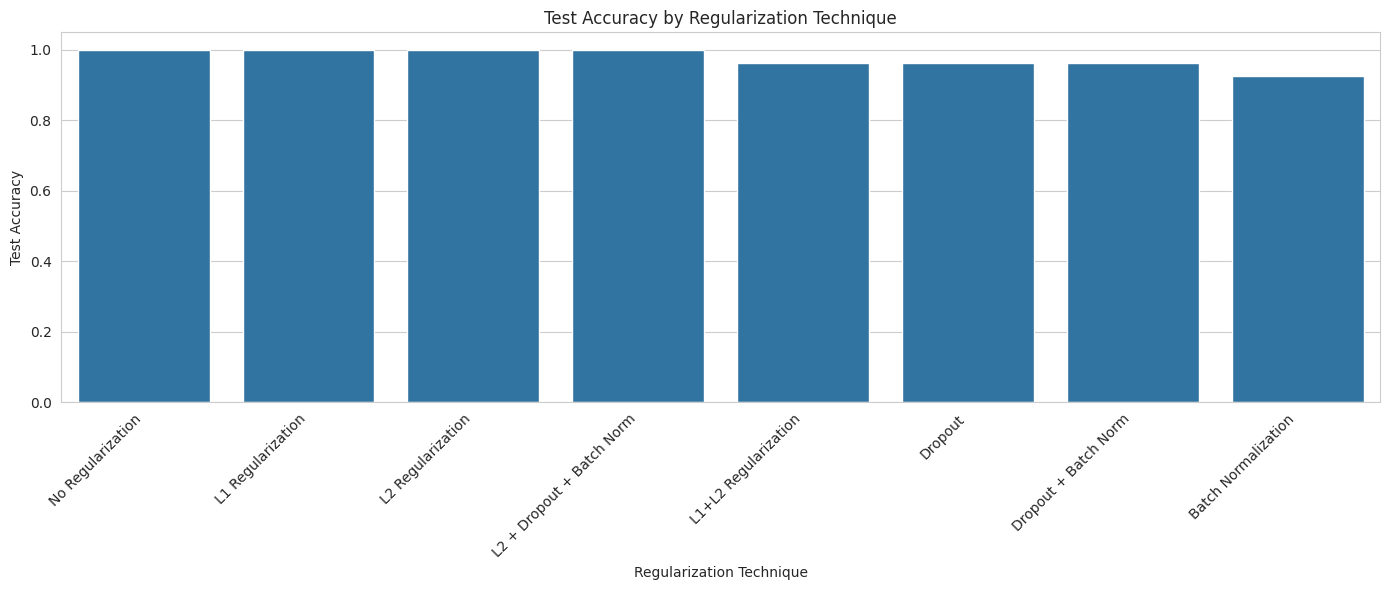

In [10]:
# Plot test accuracies
plt.figure(figsize=(14, 6))
sns.barplot(x='Configuration', y='Test Accuracy', data=results_df)
plt.title('Test Accuracy by Regularization Technique')
plt.xlabel('Regularization Technique')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

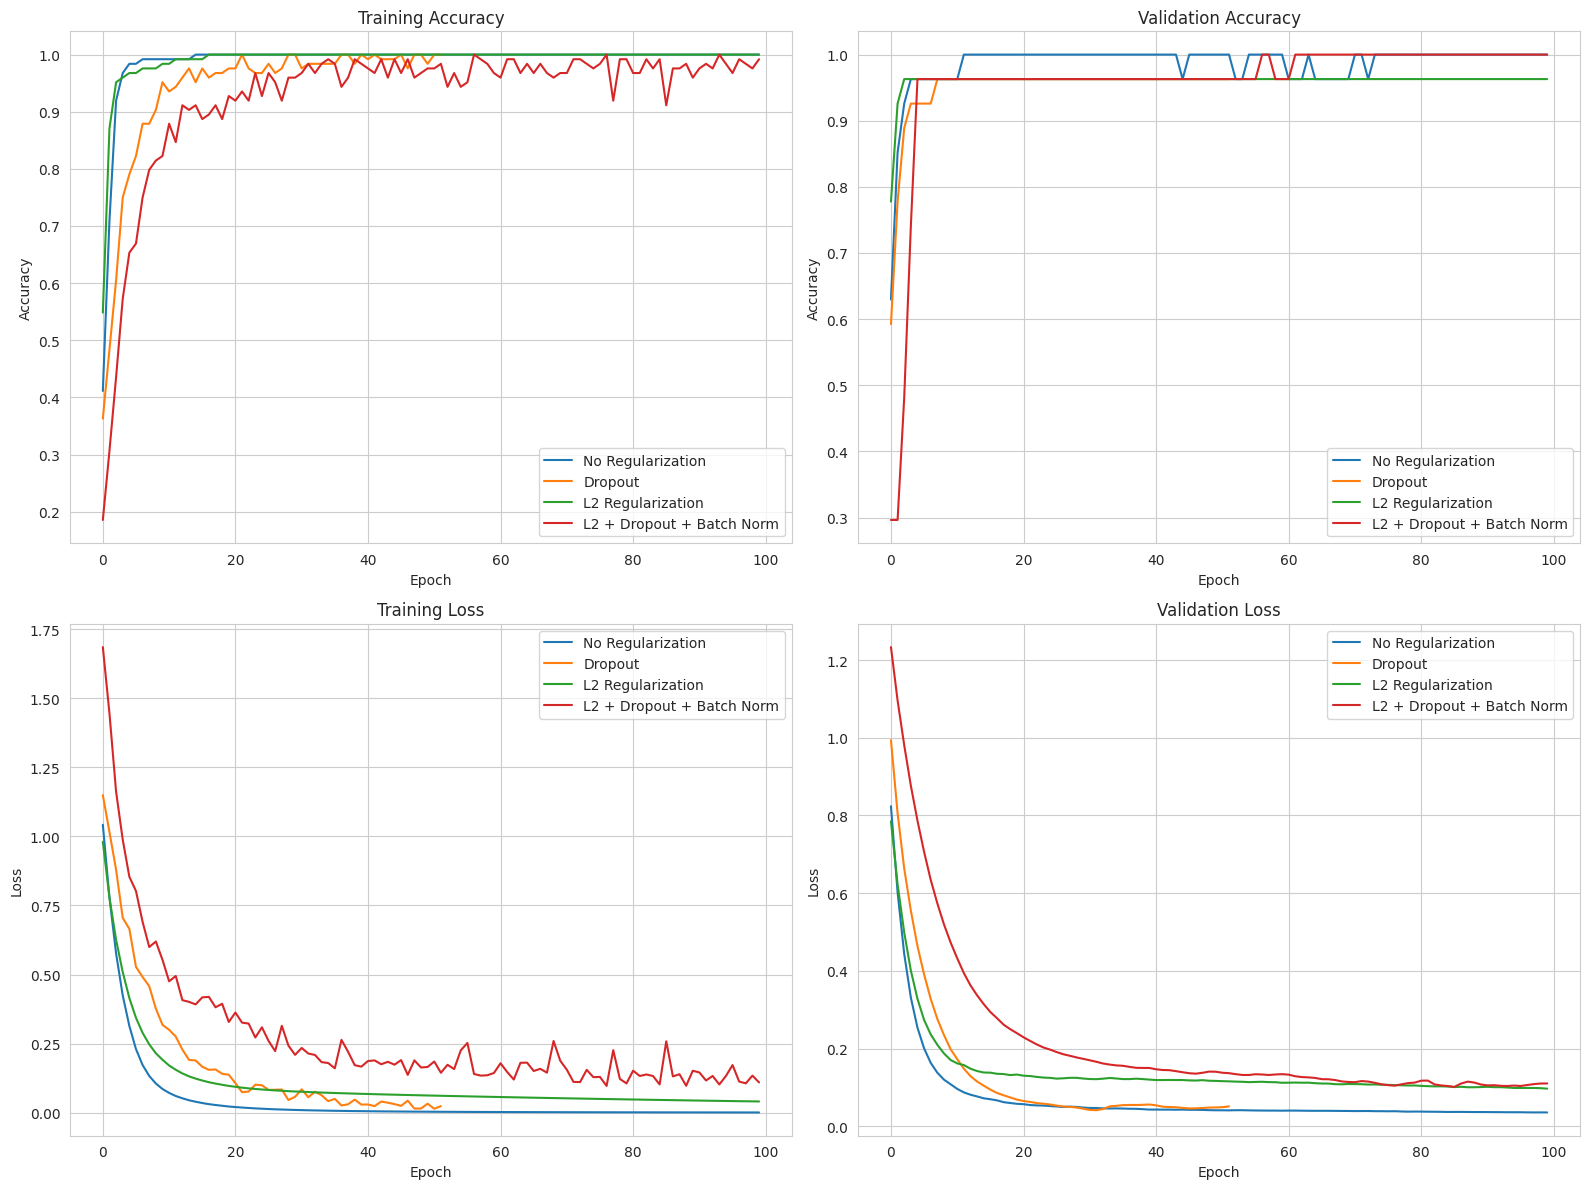

In [11]:
# Plot learning curves for selected configurations
selected_configs = ['No Regularization', 'Dropout', 'L2 Regularization', 'L2 + Dropout + Batch Norm']

plt.figure(figsize=(16, 12))

# Plot training accuracy
plt.subplot(2, 2, 1)
for config in selected_configs:
    plt.plot(histories[config].history['accuracy'], label=config)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(2, 2, 2)
for config in selected_configs:
    plt.plot(histories[config].history['val_accuracy'], label=config)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training loss
plt.subplot(2, 2, 3)
for config in selected_configs:
    plt.plot(histories[config].history['loss'], label=config)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(2, 2, 4)
for config in selected_configs:
    plt.plot(histories[config].history['val_loss'], label=config)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Best Model: No Regularization
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00         9
     class_1       1.00      1.00      1.00        11
     class_2       1.00      1.00      1.00         7

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



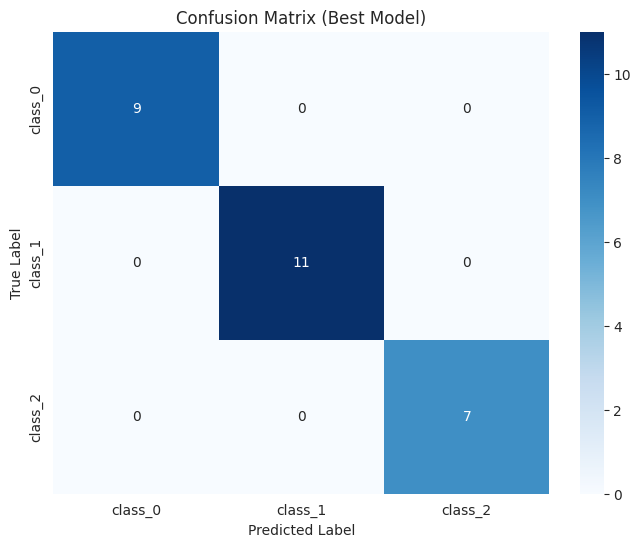

In [12]:
# Get the best model based on test accuracy
best_config = results_df.iloc[0]['Configuration']
best_model = models[best_config]

print(f"Best Model: {best_config}")

# Make predictions on the test set
y_pred_prob = best_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 3. Advanced Architectures and Functional API

So far, we've used the Sequential API to build our neural networks. However, for more complex architectures, Keras provides the Functional API, which allows for more flexibility, including:

- Models with multiple inputs or outputs
- Models with shared layers
- Models with non-sequential data flows (e.g., residual connections, multi-branch networks)

Let's implement a more advanced architecture using the Functional API.

In [13]:
def create_multi_branch_model(input_shape, num_classes=3):
    """Create a multi-branch neural network using the Functional API."""
    # Input layer
    inputs = Input(shape=(input_shape,))

    # Branch 1: Deep network
    branch1 = Dense(64, activation='relu')(inputs)
    branch1 = BatchNormalization()(branch1)
    branch1 = Dropout(0.3)(branch1)
    branch1 = Dense(32, activation='relu')(branch1)
    branch1 = BatchNormalization()(branch1)
    branch1 = Dropout(0.3)(branch1)
    branch1 = Dense(16, activation='relu')(branch1)

    # Branch 2: Wider network
    branch2 = Dense(128, activation='relu')(inputs)
    branch2 = BatchNormalization()(branch2)
    branch2 = Dropout(0.3)(branch2)
    branch2 = Dense(64, activation='relu')(branch2)

    # Branch 3: Direct connection with low regularization
    branch3 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(inputs)

    # Concatenate branches
    merged = Concatenate()([branch1, branch2, branch3])

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(merged)

    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [14]:
# Create and display the multi-branch model
multi_branch_model = create_multi_branch_model(X_train_scaled.shape[1])
multi_branch_model.summary()

Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 64)             │            896 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 64)             │            256 │ dense_24[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 64)             │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 32)             │          2,080 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 128)            │          1,792 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 32)             │            128 │ dense_25[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 128)            │            512 │ dense_27[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 32)             │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 16)             │            528 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 64)             │          8,256 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 32)             │            448 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 112)            │              0 │ dense_26[0][0],        │
│                           │                        │                │ dense_28[0][0],        │
│                           │                        │                │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 3)              │            339 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,235 (59.51 KB)

 Trainable params: 14,787 (57.76 KB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
# Visualize the model architecture (optional, requires pydot and graphviz)
try:
    from IPython.display import Image
    import pydot
    tf.keras.utils.plot_model(
        multi_branch_model,
        to_file='multi_branch_model.png',
        show_shapes=True,
        show_layer_names=True
    )
    Image('multi_branch_model.png')
except Exception as e:
    print(f"Could not visualize model: {e}")

In [16]:
# Train the multi-branch model
multi_branch_history = multi_branch_model.fit(
    X_train_scaled, y_train_one_hot,
    epochs=100,
    batch_size=16,
    validation_data=(X_val_scaled, y_val_one_hot),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.5010 - loss: 1.1404 - val_accuracy: 0.8519 - val_loss: 0.7156
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8965 - loss: 0.3934 - val_accuracy: 0.8889 - val_loss: 0.5304
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9383 - loss: 0.2733 - val_accuracy: 0.8889 - val_loss: 0.4309
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9731 - loss: 0.1471 - val_accuracy: 0.8889 - val_loss: 0.3713
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9508 - loss: 0.1706 - val_accuracy: 0.9259 - val_loss: 0.3265
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9871 - loss: 0.1007 - val_accuracy: 0.9259 - val_loss: 0.2894
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9802 - loss: 0.0951 - val_accuracy: 0.9259 - val_loss: 0.2650
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9893 - loss: 0.0725 - val_accuracy: 0.9630 - val_los

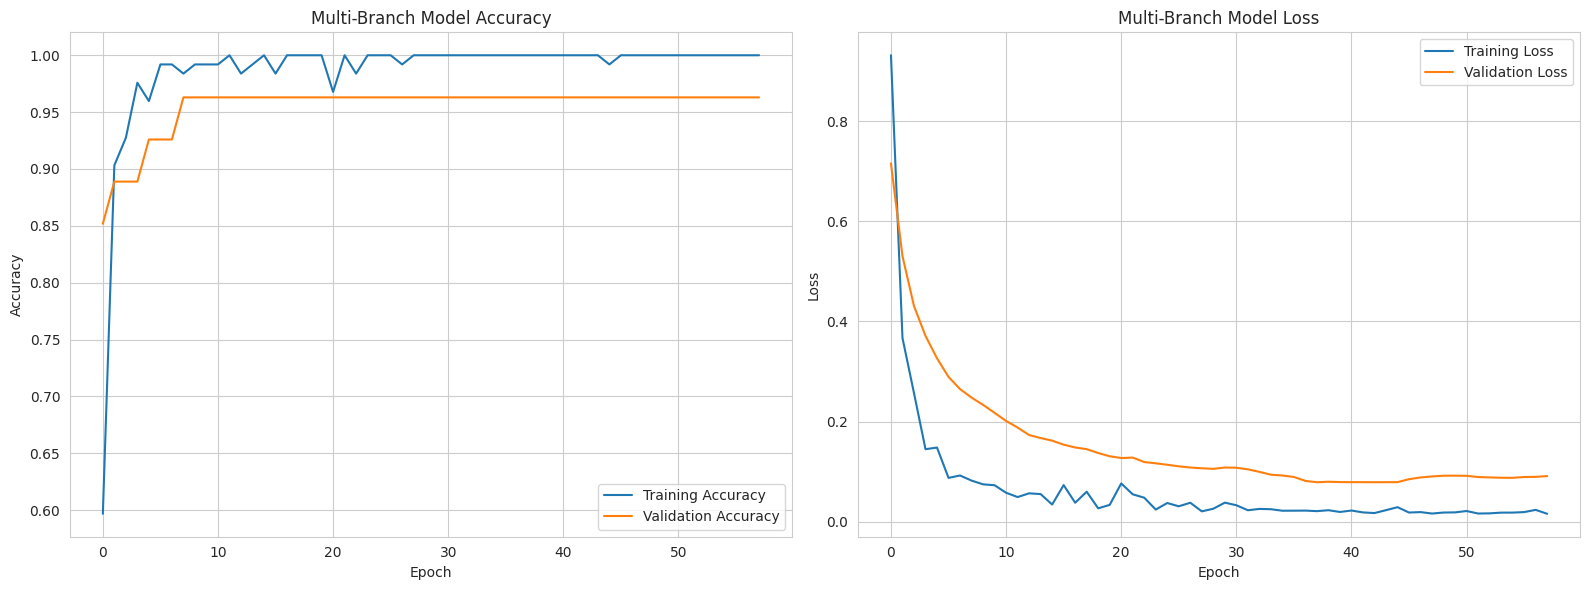

In [17]:
# Plot training history
plt.figure(figsize=(16, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(multi_branch_history.history['accuracy'], label='Training Accuracy')
plt.plot(multi_branch_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Multi-Branch Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(multi_branch_history.history['loss'], label='Training Loss')
plt.plot(multi_branch_history.history['val_loss'], label='Validation Loss')
plt.title('Multi-Branch Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Multi-Branch Model Test Accuracy: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step

Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00         9
     class_1       1.00      1.00      1.00        11
     class_2       1.00      1.00      1.00         7

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



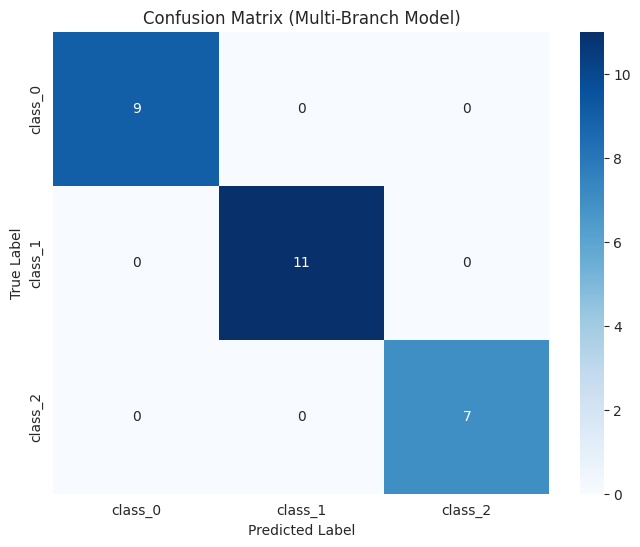

In [18]:
# Evaluate the multi-branch model on the test set
multi_branch_test_loss, multi_branch_test_acc = multi_branch_model.evaluate(X_test_scaled, y_test_one_hot, verbose=0)
print(f"Multi-Branch Model Test Accuracy: {multi_branch_test_acc:.4f}")

# Get predictions
y_pred_prob = multi_branch_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Multi-Branch Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [19]:
# Compare multi-branch model with the best previous model
comparison_df = pd.DataFrame([
    {'Model': 'Best Regular Model', 'Configuration': best_config, 'Test Accuracy': results_df.iloc[0]['Test Accuracy']},
    {'Model': 'Multi-Branch Model', 'Configuration': 'Multiple Parallel Branches', 'Test Accuracy': multi_branch_test_acc}
])

print("Model Comparison:")
comparison_df

Model Comparison:


,Model,Configuration,Test Accuracy
0,Best Regular Model,No Regularization,1.0
1,Multi-Branch Model,Multiple Parallel Branches,1.0


## 4. Advanced Optimization Techniques

Optimization is a crucial aspect of training neural networks. Let's explore some advanced optimization techniques.

In [20]:
def create_simple_model(input_shape, num_classes=3):
    """Create a simple model for optimizer comparison."""
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [21]:
# Define optimizers to compare
optimizers = {
    'SGD': SGD(learning_rate=0.01, momentum=0.9),
    'SGD with Nesterov': SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    'RMSprop': RMSprop(learning_rate=0.001),
    'Adam': Adam(learning_rate=0.001),
    'Adam with Decay': Adam(learning_rate=0.001, decay=1e-4)
}

# Train and evaluate with each optimizer
optimizer_results = []
optimizer_histories = {}

for name, optimizer in optimizers.items():
    print(f"\nTraining with {name} optimizer...")

    # Create and compile model
    model = create_simple_model(X_train_scaled.shape[1])
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    history = model.fit(
        X_train_scaled, y_train_one_hot,
        epochs=100,
        batch_size=16,
        validation_data=(X_val_scaled, y_val_one_hot),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate on validation and test sets
    val_loss, val_acc = model.evaluate(X_val_scaled, y_val_one_hot, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test_one_hot, verbose=0)

    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Store results
    optimizer_results.append({
        'Optimizer': name,
        'Validation Accuracy': val_acc,
        'Test Accuracy': test_acc,
        'Epochs Used': len(history.history['loss'])
    })

    optimizer_histories[name] = history


Training with SGD optimizer...
Epoch 85: early stopping
Restoring model weights from the end of the best epoch: 65.
Validation Accuracy: 1.0000
Test Accuracy: 0.9630

Training with SGD with Nesterov optimizer...
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 56.
Validation Accuracy: 1.0000
Test Accuracy: 0.9259

Training with RMSprop optimizer...
Restoring model weights from the end of the best epoch: 98.
Validation Accuracy: 0.9630
Test Accuracy: 0.9630

Training with Adam optimizer...
Epoch 79: early stopping
Restoring model weights from the end of the best epoch: 59.
Validation Accuracy: 0.9630
Test Accuracy: 1.0000

Training with Adam with Decay optimizer...
Epoch 89: early stopping
Restoring model weights from the end of the best epoch: 69.
Validation Accuracy: 1.0000
Test Accuracy: 0.9630


In [22]:
# Convert optimizer results to DataFrame
optimizer_df = pd.DataFrame(optimizer_results)

# Sort by test accuracy
optimizer_df = optimizer_df.sort_values('Test Accuracy', ascending=False)

# Display results
print("Optimizer Comparison:")
optimizer_df

Optimizer Comparison:


,Optimizer,Validation Accuracy,Test Accuracy,Epochs Used
3,Adam,0.962963,1.000000,79
0,SGD,1.000000,0.962963,85
2,RMSprop,0.962963,0.962963,100
4,Adam with Decay,1.000000,0.962963,89
1,SGD with Nesterov,1.000000,0.925926,76


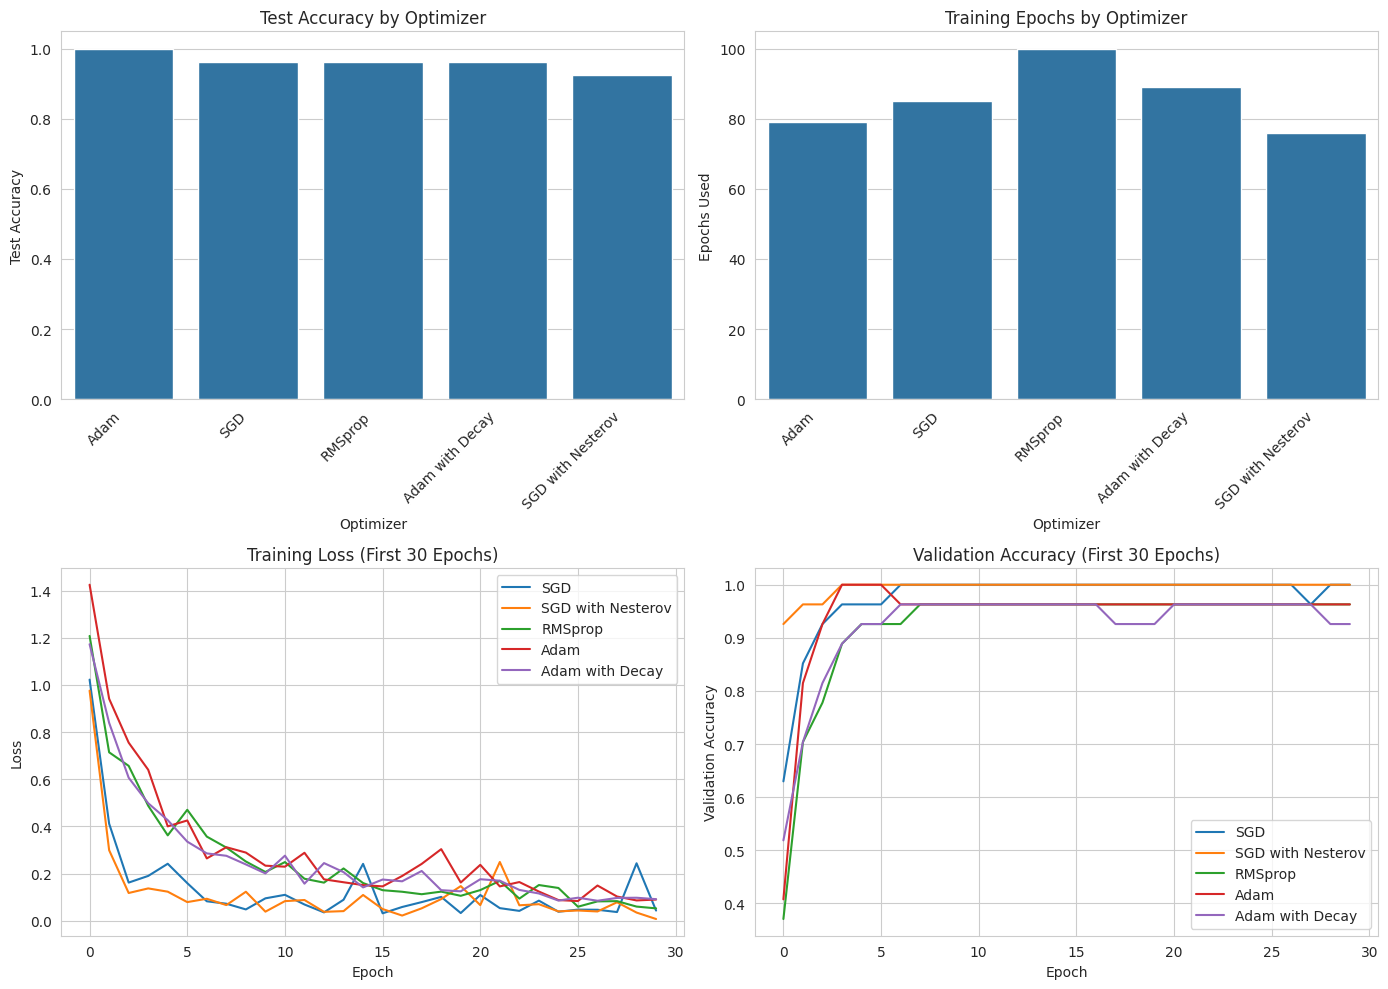

In [23]:
# Plot optimizer comparison results
plt.figure(figsize=(14, 10))

# Plot test accuracies
plt.subplot(2, 2, 1)
sns.barplot(x='Optimizer', y='Test Accuracy', data=optimizer_df)
plt.title('Test Accuracy by Optimizer')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')

# Plot epochs used
plt.subplot(2, 2, 2)
sns.barplot(x='Optimizer', y='Epochs Used', data=optimizer_df)
plt.title('Training Epochs by Optimizer')
plt.ylabel('Epochs Used')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')

# Plot training loss curves
plt.subplot(2, 2, 3)
for name in optimizers.keys():
    plt.plot(optimizer_histories[name].history['loss'][:30], label=name)  # First 30 epochs for clarity
plt.title('Training Loss (First 30 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot validation accuracy curves
plt.subplot(2, 2, 4)
for name in optimizers.keys():
    plt.plot(optimizer_histories[name].history['val_accuracy'][:30], label=name)  # First 30 epochs
plt.title('Validation Accuracy (First 30 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()